#  Movie Sentiment Classifier using fast text embedding(LSTM) vs CNN model  

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import codecs
from tqdm import tqdm

from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import gensim
import time

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/arditoibryan/Projects/master/20200602_Twitter_Sentiment_Analysis/movie_review.csv')

In [3]:
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [4]:
df.shape

(64720, 6)

In [5]:
df['tag'].value_counts()

pos    32937
neg    31783
Name: tag, dtype: int64

Tags are the target in our dataset where 'pos' stands for positive and 'neg' is negative. We drop the columns which are not required.

In [6]:
df = df.drop(['fold_id', 'cv_tag', 'html_id', 'sent_id'], axis=1)

In [7]:
df.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [8]:
df.columns = ['tweets', 'sentiment']

In [9]:
df.head()

,tweets,sentiment
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [10]:
# change sentiment value to 0 or 1
df['sentiment'] = [1 if s=='pos' else 0 for s in df['sentiment']]

In [11]:
df.head()

,tweets,sentiment
0,films adapted from comic books have had plenty...,1
1,"for starters , it was created by alan moore ( ...",1
2,to say moore and campbell thoroughly researche...,1
3,"the book ( or "" graphic novel , "" if you will ...",1
4,"in other words , don't dismiss this film becau...",1


In [12]:
df_preprocess = df.copy()

In [13]:
tweets = df_preprocess.tweets
tweets.head()

0    films adapted from comic books have had plenty...
1    for starters , it was created by alan moore ( ...
2    to say moore and campbell thoroughly researche...
3    the book ( or " graphic novel , " if you will ...
4    in other words , don't dismiss this film becau...
Name: tweets, dtype: object

In [14]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/', ',', '(', ')', '.']

removeWordWithChar(tweets[3], char_list)

'the book or " graphic novel " if you will is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes'

In [15]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [16]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [17]:
tweets_tokens = tokenize(tweets_cleaned)

In [18]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [19]:
tweets_filtered = removeSW(tweets_tokens)

In [20]:
def stem(texts_filtered):
    stemmer=PorterStemmer()
    texts_stem = []

    for i, val in enumerate(texts_filtered):
        text_stem = []
        for word in val:
            text_stem.append(stemmer.stem(word))
        texts_stem.append(text_stem)
    return texts_stem

In [21]:
tweets_stem = stem(tweets_filtered)

In [22]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word))
        texts_lem.append(text_lem)
    
    return texts_lem

In [23]:
tweets_lem = lemma(tweets_stem)

In [24]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [25]:
df_preprocess['tweet'] = tweets_ready

In [26]:
df_preprocess= df_preprocess[['tweet', 'sentiment']]

In [27]:
df_preprocess.head()

,tweet,sentiment
0,film adapt comic book plenti success whether s...,1
1,starter creat alan moor eddi campbel brought m...,1
2,moor campbel thoroughli research subject jack ...,1
3,book graphic novel page long includ nearli con...,1
4,word dismiss film sourc,1


In [28]:
df_preprocess['sentiment'].value_counts()

1    32937
0    31783
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

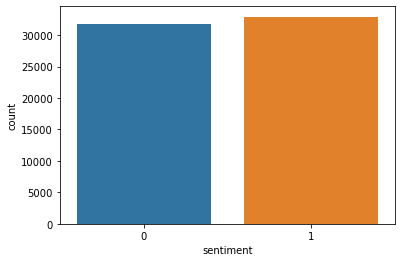

In [63]:
sns.countplot(x="sentiment", data=df_preprocess)

The dataset is balanced

In [29]:
# Utilize the keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 24718


### Fast Text Embedding & Utilize Pretrained models

In [30]:
FASTEXT_EMB = 'wiki-news-300d-1M.vec'
EMBEDDING_DIM = 300

In [31]:
embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [01:53, 8805.04it/s]

found 999995 word vectors


In [32]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [33]:
encoded_text=tokenizer.texts_to_sequences(df_preprocess.tweet)

In [34]:
max_sequence_length = 30
X=pad_sequences(encoded_text, maxlen=max_sequence_length, padding='post')
y=df_preprocess['sentiment']

In [35]:
batch_size = 512
epoch = 15

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 48540
Test Data size 16180


In [37]:
embedding_matrix.shape

(24718, 300)

In [38]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

We also utilize early stopping.

In [39]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=10)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

#### Create a bidirectional LSTM model

In [40]:
inputs = tf.keras.Input(shape=(max_sequence_length,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.4)(x)

# LSTM (bidirectional)
x = Bidirectional(LSTM(128, dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

2022-03-25 06:47:22.414724: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=['accuracy'])

In [42]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/15
95/95 [==============================] - 82s 792ms/step - loss: 0.6844 - accuracy: 0.5572 - val_loss: 0.6716 - val_accuracy: 0.5828 - lr: 0.0100
Epoch 2/15
95/95 [==============================] - 72s 754ms/step - loss: 0.6714 - accuracy: 0.5845 - val_loss: 0.6588 - val_accuracy: 0.6011 - lr: 0.0100
Epoch 3/15
95/95 [==============================] - 71s 743ms/step - loss: 0.6643 - accuracy: 0.5964 - val_loss: 0.6514 - val_accuracy: 0.6093 - lr: 0.0100
Epoch 4/15
95/95 [==============================] - 70s 739ms/step - loss: 0.6552 - accuracy: 0.6121 - val_loss: 0.6477 - val_accuracy: 0.6176 - lr: 0.0100
Epoch 5/15
95/95 [==============================] - 70s 740ms/step - loss: 0.6477 - accuracy: 0.6224 - val_loss: 0.6417 - val_accuracy: 0.6256 - lr: 0.0100
Epoch 6/15
95/95 [==============================] - 69s 730ms/step - loss: 0.6394 - accuracy: 0.6309 - val_loss: 0.6386 - val_accuracy: 0.6322 - lr: 0.0100
Epoch 7/15
95/95 [==============================] - 70s 740ms/st

In [43]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

506/506 [==============================] - 16s 32ms/step - loss: 0.6473 - accuracy: 0.6355
Accuracy: 63.55%


In [44]:
# Predicting on the Test dataset.
y_pred = model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>0.5, 1, 0)

# Printing out the Evaluation metrics. 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_pred,y_test)
print(cm)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

[[4869 2781]
 [3117 5413]]
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      7986
           1       0.63      0.66      0.65      8194

    accuracy                           0.64     16180
   macro avg       0.64      0.64      0.64     16180
weighted avg       0.64      0.64      0.64     16180



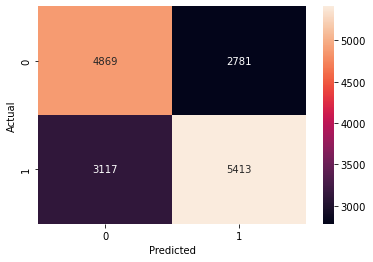

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [46]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"

In [47]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.6 else POSITIVE

In [50]:
def predict(text):
    print(text)
    start_at = time.time()
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length)
    # Predict
    score = model.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [51]:
predict("The movie was aweful")

The movie was aweful


{'label': 'NEGATIVE',
 'score': 0.3261941075325012,
 'elapsed_time': 0.8814871311187744}

In [52]:
predict("The film was creative and surprising")

The film was creative and surprising


{'label': 'POSITIVE',
 'score': 0.9249616861343384,
 'elapsed_time': 0.06656408309936523}

### CNN modele

In [64]:
embedding_dim=100

model2=Sequential()
model2.add(Embedding(vocabulary_size, embedding_dim, input_length = max_sequence_length))

model2.add(Conv1D(64, 7, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Dropout(0.5))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(16, activation='relu'))

model2.add(GlobalMaxPooling1D())

model2.add(Dense(1, activation='sigmoid'))

In [65]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
history=model2.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/15
1517/1517 [==============================] - 77s 49ms/step - loss: 0.6547 - accuracy: 0.6032 - val_loss: 0.6343 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 2/15
1517/1517 [==============================] - 58s 38ms/step - loss: 0.5450 - accuracy: 0.7239 - val_loss: 0.6011 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 3/15
1517/1517 [==============================] - 62s 41ms/step - loss: 0.4463 - accuracy: 0.7827 - val_loss: 0.6158 - val_accuracy: 0.6549 - lr: 0.0010
Epoch 4/15
1517/1517 [==============================] - 59s 39ms/step - loss: 0.3484 - accuracy: 0.8361 - val_loss: 0.6247 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 5/15
1517/1517 [==============================] - 69s 45ms/step - loss: 0.2749 - accuracy: 0.8724 - val_loss: 0.6559 - val_accuracy: 0.6693 - lr: 0.0010
Epoch 6/15
1517/1517 [==============================] - 62s 41ms/step - loss: 0.2255 - accuracy: 0.8943 - val_loss: 0.7402 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 7/15
1517/1517 [========================

In [67]:
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

506/506 [==============================] - 2s 4ms/step - loss: 1.0571 - accuracy: 0.6614
Accuracy: 66.14%


In [68]:
def predict(text):
    print(text)
    start_at = time.time()
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length)
    # Predict
    score = model2.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [69]:
predict("That movie was absolutely awful")

That movie was absolutely awful


{'label': 'NEGATIVE',
 'score': 0.2474968135356903,
 'elapsed_time': 0.32123589515686035}

In [70]:
predict("The film was creative and surprising")

The film was creative and surprising


{'label': 'NEGATIVE',
 'score': 0.4621288776397705,
 'elapsed_time': 0.08126425743103027}